In [2]:
import pandas as pd
def load_citibike(): 
    data_mine = pd.read_csv("citibike.csv") 
    data_mine['one'] = 1 
    data_mine['starttime'] = pd.to_datetime(data_mine.starttime) 
    data_starttime = data_mine.set_index("starttime") 
    data_resampled = data_starttime.resample("3h").sum().fillna(0) 
    return data_resampled.one 
citibike = load_citibike() 

In [3]:
print("данные Citi Bike:\n{}".format(citibike.head()))

данные Citi Bike:
starttime
2015-08-01 00:00:00     3.0
2015-08-01 03:00:00     0.0
2015-08-01 06:00:00     9.0
2015-08-01 09:00:00    41.0
2015-08-01 12:00:00    39.0
Freq: 3H, Name: one, dtype: float64


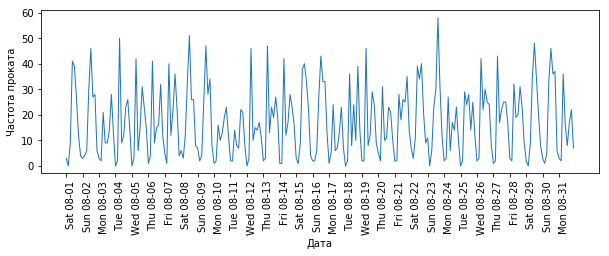

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3)) 
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), 
                       freq='D') 
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left") 
plt.plot(citibike, linewidth=1) 
plt.xlabel("Дата") 
plt.ylabel("Частота проката")
plt.show()

In [5]:
# извлекаем значения зависимой переменной (количество велосипедов, взятых в прокат) 
y = citibike.values 
# преобразуем время в формат POSIX с помощью "%s" 
X = citibike.index.astype("int64").values.reshape(-1, 1)//10**9

In [6]:
import matplotlib.pyplot as plt
#используем первые 184 точки данных для обучения, а остальные для тестирования 
n_train = 184 
# функция, которая строит модель на данном наборе признаков и визуализирует ее 
def eval_on_features(features, target, regressor): 
    # разбиваем массив признаков на обучающую и тестовую выборки 
    X_train, X_test = features[:n_train], features[n_train:] 
    # также разбиваем массив с зависимой переменной 
    y_train, y_test = target[:n_train], target[n_train:] 
    regressor.fit(X_train, y_train) 
    print("R^2 для тестового набора: {:.2f}".format(regressor.score(X_test, y_test))) 
    y_pred = regressor.predict(X_test) 
    y_pred_train = regressor.predict(X_train) 
    plt.figure(figsize=(10, 3)) 
 
    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, 
               ha="left") 
 
    plt.plot(range(n_train), y_train, label="обуч") 
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="тест") 
    plt.plot(range(n_train), y_pred_train, '--', label="прогноз обуч") 
 
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="прогноз тест") 
    plt.legend(loc=(1.01, 0)) 
    plt.xlabel("Дата") 
    plt.ylabel("Частота проката")     

R^2 для тестового набора: -0.04


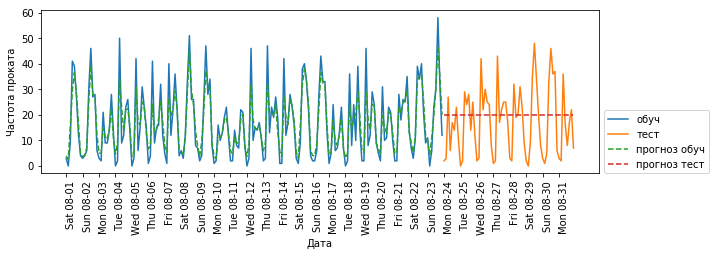

In [7]:
from sklearn.ensemble import RandomForestRegressor 
regressor = RandomForestRegressor(n_estimators=100, random_state=0) 
plt.figure() 
eval_on_features(X, y, regressor)
plt.show()

R^2 для тестового набора: 0.60


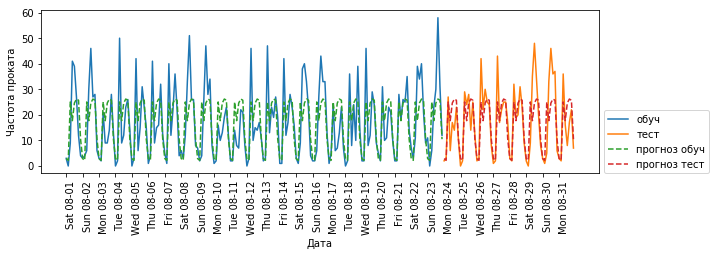

In [8]:
X_hour = citibike.index.hour.values.reshape(-1, 1) 
eval_on_features(X_hour, y, regressor)
plt.show()

R^2 для тестового набора: 0.84


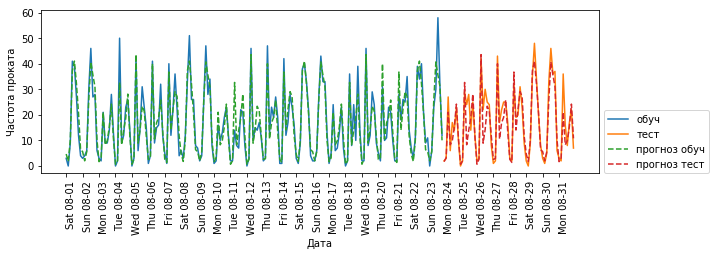

In [10]:
import numpy as np
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1), 
                         citibike.index.hour.values.reshape(-1, 1)]) 
eval_on_features(X_hour_week, y, regressor)
plt.show()

R^2 для тестового набора: 0.13


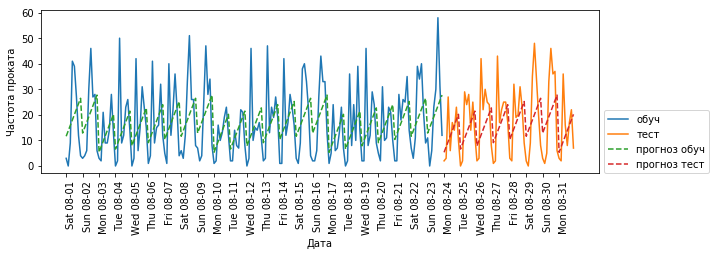

In [11]:
#LinearRegression
from sklearn.linear_model import LinearRegression 
eval_on_features(X_hour_week, y, LinearRegression()) 
plt.show()

R^2 для тестового набора: 0.62


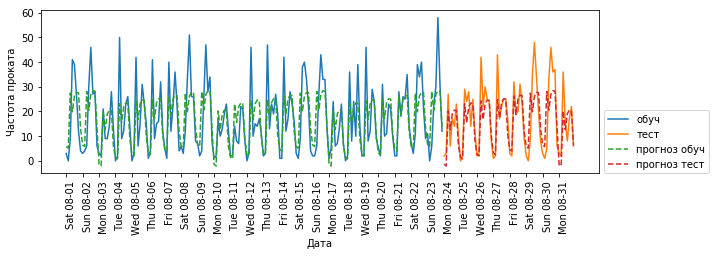

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
enc = OneHotEncoder() 
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray() 
eval_on_features(X_hour_week_onehot, y, Ridge()) 
plt.show()

R^2 для тестового набора: 0.85


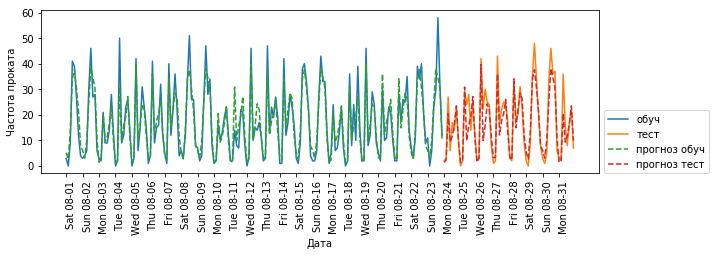

In [16]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, 
                                      include_bias=False) 
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot) 
lr = Ridge() 
eval_on_features(X_hour_week_onehot_poly, y, lr) 
plt.show()

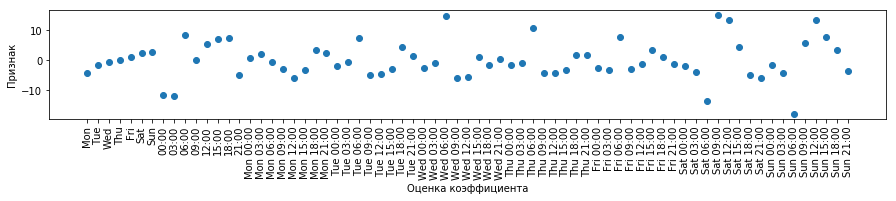

In [17]:
hour = ["%02d:00" % i for i in range(0, 24, 3)] 
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"] 
features = day + hour
features_poly = poly_transformer.get_feature_names(features) 
features_nonzero = np.array(features_poly)[lr.coef_ != 0] 
coef_nonzero = lr.coef_[lr.coef_ != 0]
plt.figure(figsize=(15, 2)) 
plt.plot(coef_nonzero, 'o') 
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90) 
plt.xlabel("Оценка коэффициента") 
plt.ylabel("Признак")
plt.show()